# Introduction
In this project I did a classification problem, using AutoEncoder as Dimensionality reduction tool.

The dataset is the clinical data of patients who tested for Covid19.

# Imports

In [7]:
import keras
from keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

# Data Preparation

In [8]:
covid_data = pd.read_csv('Covid Dataset.csv')
categorical_feature_mask = covid_data.dtypes == object
cateforical_cols = covid_data.columns[categorical_feature_mask].tolist()
le = LabelEncoder()
covid_data[cateforical_cols] = covid_data[cateforical_cols].apply(lambda col: le.fit_transform(col))
covid_data = covid_data.astype(float)
covid_data.head()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [12]:
# Extracting X and Y from the dataset
NUM_FEATURES = 20
X_total = covid_data.iloc[:, 0:NUM_FEATURES].values
y_total = covid_data.iloc[:,NUM_FEATURES].values


# Spltting the data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size = 0.25, random_state = 0)
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (4075, 20)
y_train: (4075,)
X_test: (1359, 20)
y_test: (1359,)


---------------

# 1. AutoEncoder as nonlinear dimensionality reduction method

Autoencoder is an unsupervised artificial neural network that compresses the data to lower dimension and then reconstructs the input back. Autoencoder finds the representation of the data in a lower dimension by focusing more on the important features getting rid of noise and redundancy. It's based on Encoder-Decoder architecture, where encoder encodes the high-dimensional data to lower-dimension and decoder takes the lower-dimensional data and tries to reconstruct the original high-dimensional data.

![picture](https://drive.google.com/uc?id=1RTZwx4xL6zFV_nUENBgWlFKLKldPoyI-)

In the above Diagram, X is the input data, z is the lower-dimension representation of input X and X’ is the reconstructed input data. The mapping of higher to lower dimensions can be linear or non-linear depending on the choice of the activation function.

In this part we're gonna implement an autoencoder using Keras framework as dimensionality reduction module.

In this notebook, we lower the dimension of our data from 20 to 2.

In [15]:
def AutoEncoder(input_dim, encode_dims, encode_dim, decode_dims=None):
    
    decode_dims = decode_dims if decode_dims else reversed(encode_dims)

    # Defining input from input_dim
    input = keras.Input(shape=(input_dim))

    # The encoder. This part will be used later as reduction tool
    encoder = keras.Sequential([
        *[layers.Dense(dim, activation='relu') for dim in encode_dims]
        ,layers.Dense(encode_dim, activation='linear')
    ], name='Encoder')
    encoded = encoder(input)
    
    # The Decoder
    decoder = keras.Sequential([
        *[layers.Dense(dim, activation='relu') for dim in decode_dims]
        ,layers.Dense(input_dim, activation='sigmoid')
    ], name='Decoder')
    decoded = decoder(encoded)

    return keras.Model(input, decoded)

In [16]:
autoencoder = AutoEncoder(20, [128, 64, 32], 2)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 Encoder (Sequential)        (None, 2)                 13090     
                                                                 
 Decoder (Sequential)        (None, 20)                13108     
                                                                 
Total params: 26,198
Trainable params: 26,198
Non-trainable params: 0
_________________________________________________________________


# Training the model
Note that we are using X_train as both input and expected output of the model.

In [17]:
def scheduler(epoch, lr):
    return lr if epoch < 10 else lr * 0.995

sch = keras.callbacks.LearningRateScheduler(scheduler)
opt = keras.optimizers.Adam(learning_rate=0.01)

autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
history = autoencoder.fit(X_train, X_train,
                epochs=400, callbacks=[sch],
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/400
64/64 [==============================] - 4s 7ms/step - loss: 0.5287 - val_loss: 0.4744 - lr: 0.0100
Epoch 2/400
64/64 [==============================] - 0s 4ms/step - loss: 0.4480 - val_loss: 0.4318 - lr: 0.0100
Epoch 3/400
64/64 [==============================] - 0s 4ms/step - loss: 0.4139 - val_loss: 0.4069 - lr: 0.0100
Epoch 4/400
64/64 [==============================] - 0s 5ms/step - loss: 0.3913 - val_loss: 0.3892 - lr: 0.0100
Epoch 5/400
64/64 [==============================] - 0s 5ms/step - loss: 0.3744 - val_loss: 0.3844 - lr: 0.0100
Epoch 6/400
64/64 [==============================] - 0s 4ms/step - loss: 0.3665 - val_loss: 0.3518 - lr: 0.0100
Epoch 7/400
64/64 [==============================] - 0s 4ms/step - loss: 0.3669 - val_loss: 0.3588 - lr: 0.0100
Epoch 8/400
64/64 [==============================] - 0s 4ms/step - loss: 0.3457 - val_loss: 0.3385 - lr: 0.0100
Epoch 9/400
64/64 [==============================] - 0s 4ms/step - loss: 0.3278 - val_loss: 0.3246 - lr:

# AutoEncoder Plots

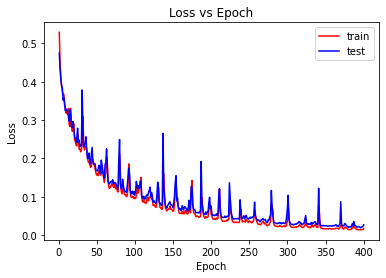

In [28]:
# Plotting Loss vs Epoch for train and test sets
x = [i + 1 for i in range(400)]
plt.plot(x, history.history['loss'], color='r', label='train')
plt.plot(x, history.history['val_loss'], color='b', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

In [29]:
def show_scatter(encoder, X, y, title):
    colors = ['blue', 'red']
    for layer in encoder:
        X = layer(X)
    fig, ax = plt.subplots()
    for i in (0, 1):
        mask = (y == i)
        x = X[mask]
        label = 'YES' if i else 'NO'
        ax.scatter(x[:, 0], x[:, 1], c=colors[i],s=2, label=label, edgecolors='none')
    
    ax.legend()
    ax.grid(True)
    plt.title(title)
    plt.show()

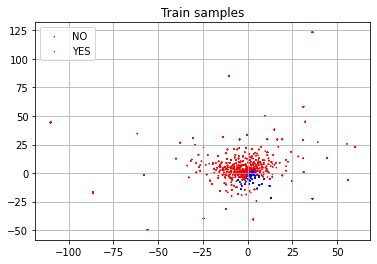

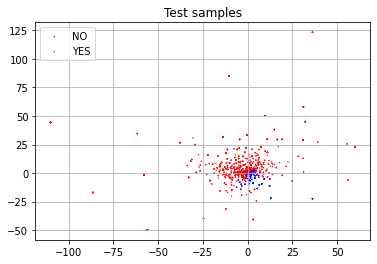

In [30]:
# Plotting the encoded data
encoder = autoencoder.layers[:2]

show_scatter(encoder, X_train, y_train, 'Train samples')
show_scatter(encoder, X_test, y_test, 'Test samples')

# The Classifier
Now we get rid of the decoder part of our AutoEncder and replace it with a new MLP model ```head```.

In [31]:
head = keras.Sequential([
    *[layers.Dense(dim, activation='relu') for dim in [16, 32, 64]],
    layers.Dense(1, activation='sigmoid')
])

classifier = keras.Sequential([
    *autoencoder.layers[:2],
    head
])
classifier.layers[0].trainable = False
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 2)                 13090     
                                                                 
 sequential (Sequential)     (None, 1)                 2769      
                                                                 
Total params: 15,859
Trainable params: 2,769
Non-trainable params: 13,090
_________________________________________________________________


In [32]:
sch = keras.callbacks.LearningRateScheduler(scheduler)
opt = keras.optimizers.Adam(learning_rate=0.01)

classifier.compile(optimizer=opt, loss='binary_crossentropy')
classification_history = classifier.fit(X_train, y_train,
                epochs=200, callbacks=[sch],
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, y_test))

Epoch 1/200
64/64 [==============================] - 1s 7ms/step - loss: 0.2014 - val_loss: 0.1768 - lr: 0.0100
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 0.1504 - val_loss: 0.1619 - lr: 0.0100
Epoch 3/200
64/64 [==============================] - 0s 4ms/step - loss: 0.1470 - val_loss: 0.1702 - lr: 0.0100
Epoch 4/200
64/64 [==============================] - 0s 4ms/step - loss: 0.1369 - val_loss: 0.1556 - lr: 0.0100
Epoch 5/200
64/64 [==============================] - 0s 4ms/step - loss: 0.1281 - val_loss: 0.1423 - lr: 0.0100
Epoch 6/200
64/64 [==============================] - 0s 4ms/step - loss: 0.1241 - val_loss: 0.1727 - lr: 0.0100
Epoch 7/200
64/64 [==============================] - 0s 4ms/step - loss: 0.1292 - val_loss: 0.1398 - lr: 0.0100
Epoch 8/200
64/64 [==============================] - 0s 4ms/step - loss: 0.1180 - val_loss: 0.1302 - lr: 0.0100
Epoch 9/200
64/64 [==============================] - 0s 4ms/step - loss: 0.1072 - val_loss: 0.1274 - lr:

# Plots (again)

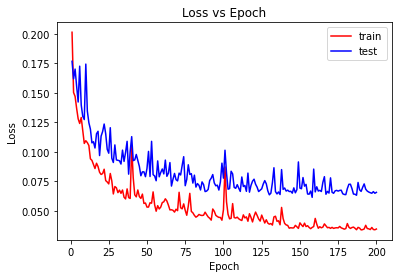

In [34]:
# Plotting Loss vs Epoch for train and test sets
x = [i + 1 for i in range(200)]
plt.plot(x, classification_history.history['loss'], color='r', label='train')
plt.plot(x, classification_history.history['val_loss'], color='b', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

# Choosing threshold
Right now we have a model which outputs a number between 0 and 1. In order to make decision about weather or not the patient has the disease, we need to choose a threshold between 0 and 1. This threshold will then be used to classify samples as having or not having the disease.

In [36]:
y_pred = np.array(classifier(X_test)).squeeze()

In [42]:
best_threshold = None
best_f1 = 0
for threshold in [0.3 + i/1000 for i in range(700)]:
    pred = (y_pred > threshold).astype(int)
    f1 = f1_score(pred, y_test)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
print(f'best threshold: {best_threshold}')

best threshold: 0.696


# Classification Report and Confusion Matrix

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       261
         1.0       1.00      0.98      0.99      1098

    accuracy                           0.98      1359
   macro avg       0.96      0.99      0.97      1359
weighted avg       0.98      0.98      0.98      1359



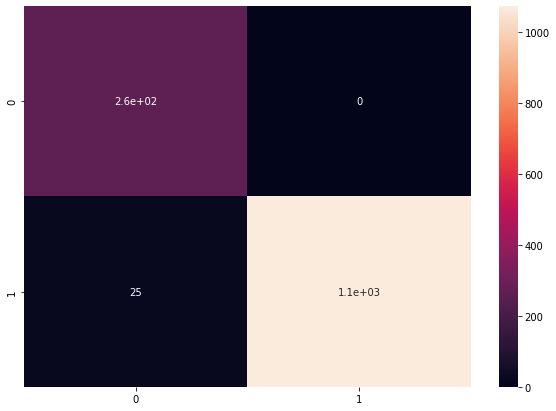

In [45]:
best_pred = (y_pred > best_threshold).astype(int)
print(classification_report(y_test, best_pred))
df_cm = pd.DataFrame(confusion_matrix(y_test, best_pred))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# Conclusion
In this notebook we achieved 98% accuracy and f1-score on the test set which is great.